In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


installing all required libraries

In [ ]:
# @title Adding required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np



Traning a model a for feature extraction of the image is very big task because it required GPU and lots of image data of all kinds like style images and object images, firstly i tried to do this by making a deep learning model but for 2000 images but it was taking very much time to train the model because to i had big network
So, now i am using Pretrained VGG19 model for only features extraction part only

In [ ]:
model=models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.9MB/s]


VGG19 network looks like this, it have 16 convolution layer and 3 fully connected layer we don't need these fully connected layer because these fully connected layer needed for special tasks like classification or object detection but we need only features of the image at different levels, this network have 6 blocks 5 convolution blocks and one fully connected layers block, we need only convolution blocks, part below we clearly can see numbering of different convolution and relu and maxpool layers


In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

we selected first convolution layer of each convolution block for loss calculation of features, with above mentioned index
first block have 64 channels, 2nd have 128, 3rd have 256, 4th have 512 and 5th also have 512 channels

In [ ]:
my_features_layers=['0','5','10','19','28']

Here we have made a VGG network custom class using pytorch, this class have chosen features layer numbering and model , forward function will return a list of the features tensors of the image at different levels of the network

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG,self).__init__()
    self.chosen_features=my_features_layers
    self.model=models.vgg19(pretrained=True).features[:29]

  def forward(self,x):
    features=[]
    for layer_num,layer in enumerate(self.model):
      x=layer(x)

      if str(layer_num) in self.chosen_features:
        features.append(x)

    return features




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
image_size=356

made loader to make images of the same size and converting image in pytorch tensors

In [ ]:
loader=transforms.Compose(
   [ transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
   ]
)

function to load image, it takes image path as input, it will convert the image in required size and adding one extra dimension to the tesor and at 0th index, lets first our image had dimension (3,356,356) now this unsqueeze(0) will make it (1,3,356,356) here one represents batch_size ,3 represents the number of channles because our image is RGB images, (356,356) represents heights and width of image

In [ ]:
def load_image(image_path):
  image=Image.open(image_path)
  image=loader(image).unsqueeze(0)
  return image.to(device)

If you want to run this file you have to first download and have to put the link of that image



In [159]:
original_image_path="/content/drive/MyDrive/Colab Notebooks/Dashtoon/content2.jpg"

path of Original image at wich we have to apply style transfer

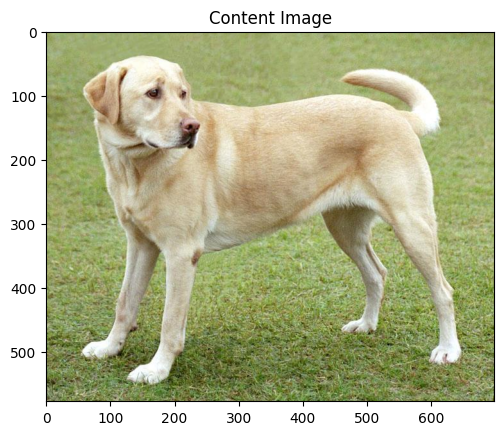

In [160]:

img = Image.open(original_image_path)

plt.imshow(img)
plt.title('Content Image')
plt.show()

If you want to run this file you have to first download and have to put the link of that image

In [ ]:
style_image_path="/content/drive/MyDrive/Colab Notebooks/Dashtoon/style3.jpg"

path of the style image, the style wich we have to transfer it to original image

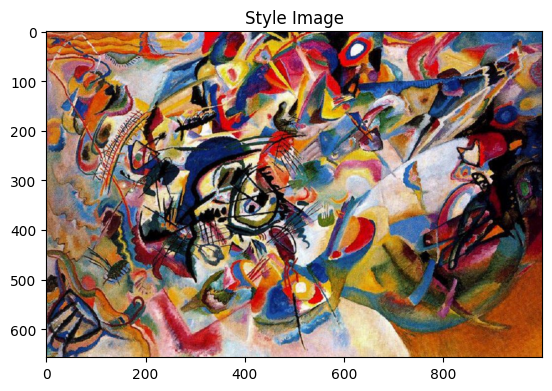

In [ ]:

img = Image.open(style_image_path)

plt.imshow(img)
plt.title('Style Image')
plt.show()

In [ ]:
original_image=load_image(original_image_path)
style_image=load_image(style_image_path)

In [ ]:
print(original_image.shape)

torch.Size([1, 3, 356, 356])


as mentioned above now each image tensor have shape (1,3,356,356)

Here i made object of VGG class, and put it in evaluation mode, it is pretrained model we don't want to update the parameters of this model, we want to use this model only to extract features of the image

In [ ]:
model=VGG().to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


here, intialized the generated_image with original image and put its parameters require_grad as True, now we update the features of this generated image and will do the style transfer process on this generated_image.
we can intialize this generated image with random number, but we intialized it with original image,

 To intialize it with random number

 generated_image=torch.randn(original_image.shape,device=device,require_grad=True)

In [ ]:
generated_image=original_image.clone().requires_grad_(True)

these are the parameters for the style tranfering, number of epochs we set as 3000 leaning rate as 0.01

In [ ]:
total_steps=3000
learning_rate=0.01


Using Adam optimizer we will update the generated image, passed the generated image paraters for learning and passed leanring rate to the optimizer

In [ ]:
optimizer=optim.Adam([generated_image],lr=learning_rate)

For Tranfering the style designing of the loss function is important part

we have three images original_image, generated_image and style_image at each step calculated the loss of the original_image features in generated and calculated loss of the style_image features in the generated image, we have to minimize both the losses but these both losses are opposite to each other like, when we will try to minimize original_image feature loss then style_image feature loss will increase , so have to reach a optimal point where both loss are optimal and also style transfer also done

For content_loss of original_image we calculated MSE loss between original_image feature and generated_image features and for style_loss
 calculated Gram_matrix of the style_image features and generated_image features

 Gram_matrix of w matrix will be Gram_matrix=W*(W)transpose

 style_loss will be the mse loss of gram_matrix of style_image features and generated_image feature


In [ ]:
alpha=1
beta=0.01

final_loss= alpha* content_loss+ beta* style_loss

Alph is coffiecient for content loss and beta is for style loss, these values are hyperparameter i tried different values of the alpha and beta found good style tranfer for these values, it is possible that any another good values exists we can tune these values

In [ ]:
print_interval=500

In [ ]:
content_lossx=[]
style_lossx=[]
total_lossx=[]
num_epoch=[]

In [ ]:
for step in range(total_steps):
  generated_features=model(generated_image)
  original_features=model(original_image)
  style_features=model(style_image)
  style_loss=content_loss=0;
  for gen_feature,orig_feature,style_feature in zip(
      generated_features,original_features,style_features):
    batch_size,channel,height,width=gen_feature.shape
    content_loss+=torch.mean((gen_feature-orig_feature)**2)

    ##compute gram matrix
    G=gen_feature.view(channel,height*width).mm(
        gen_feature.view(channel,height*width).t()
    )
    A=style_feature.view(channel,height*width).mm(
        style_feature.view(channel,height*width).t()
    )

    style_loss+=torch.mean((G-A)**2)
  total_loss=alpha*content_loss+beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
    # Print generated image every 300 steps
  if (step+1)%200 ==0:
    num_epoch.append(step)
    content_lossx.append(content_loss)
    style_lossx.append(style_loss)
    total_lossx.append(total_loss)
  if (step + 1) % print_interval == 0:
    image_array = generated_image.cpu().detach().numpy()
    # Transpose the array to match the shape expected by imshow
    image_array = np.transpose(image_array, (0, 2, 3, 1))
    # Display the image
    plt.imshow(image_array.squeeze())
    plt.title(f'generated_image after {step} epochs')  # Optional: Turn off axis labels
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

This is the style tranfer of on the generated_image at each epoch, calculated loss for all the 5 layer ['0', '5','10', '19','28'] and run epochs to minimize this loss

In [ ]:

generated_image.shape
#generated_image is now updated tensor of the (1, 356, 356, 3) shape

torch.Size([1, 3, 356, 356])

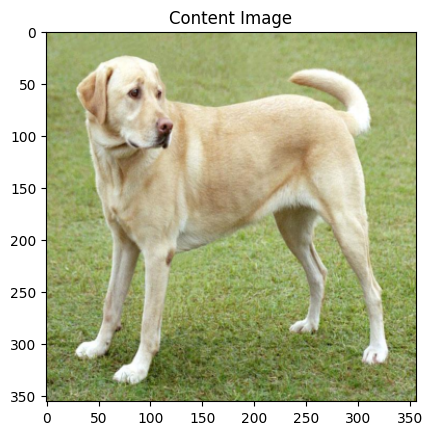

In [ ]:
image_array = original_image.cpu().detach().numpy()

# Transpose the array to match the shape expected by imshow
image_array = np.transpose(image_array, (0, 2, 3, 1))

# Display the image
plt.imshow(image_array.squeeze())
plt.title('Content Image')  # Optional: Turn off axis labels
plt.show()

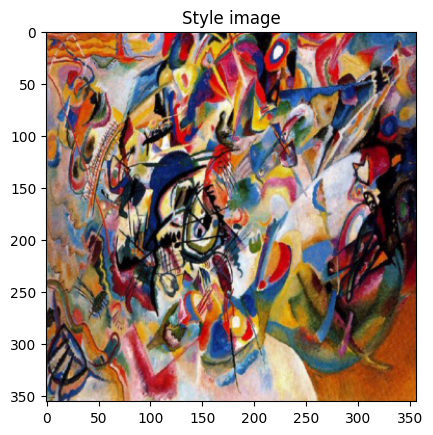

In [ ]:
image_array = style_image.cpu().detach().numpy()

# Transpose the array to match the shape expected by imshow
image_array = np.transpose(image_array, (0, 2, 3, 1))

# Display the image
plt.imshow(image_array.squeeze())
plt.title('Style image')  # Optional: Turn off axis labels
plt.show()

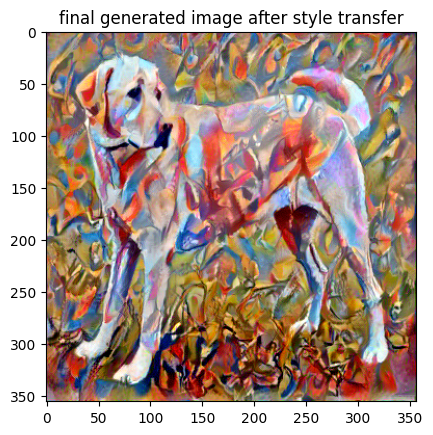

In [ ]:
image_array = generated_image.cpu().detach().numpy()

# Transpose the array to match the shape expected by imshow
image_array = np.transpose(image_array, (0, 2, 3, 1))

# Display the image
plt.imshow(image_array.squeeze())
plt.title('final generated image after style transfer')  # Optional: Turn off axis labels
plt.show()

In [ ]:
content_lossx = [item.item() for item in content_lossx]

Text(0.5, 1.0, 'content loss and epochs')

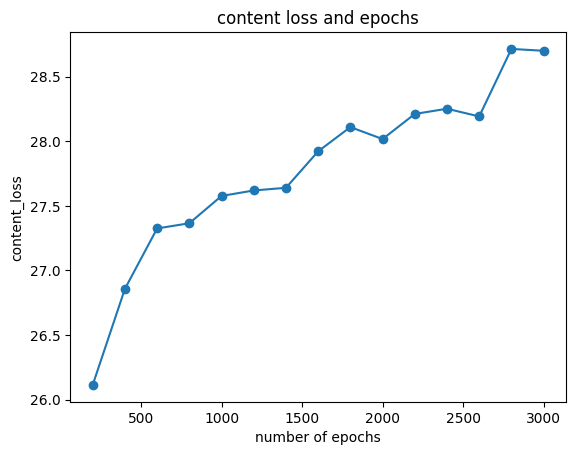

In [ ]:
plt.plot(num_epoch, content_lossx, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('number of epochs')
plt.ylabel('content_loss')
plt.title('content loss and epochs')

In [ ]:
style_lossx = [item.item() for item in style_lossx]

Text(0.5, 1.0, 'Style loss and epochs')

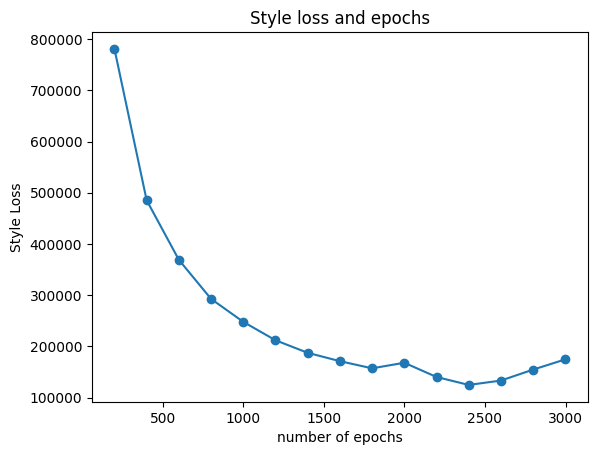

In [ ]:
plt.plot(num_epoch, style_lossx, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('number of epochs')
plt.ylabel('Style Loss')
plt.title('Style loss and epochs')

In [ ]:
total_lossx = [item.item() for item in total_lossx]

Text(0.5, 1.0, 'Total loss and epochs')

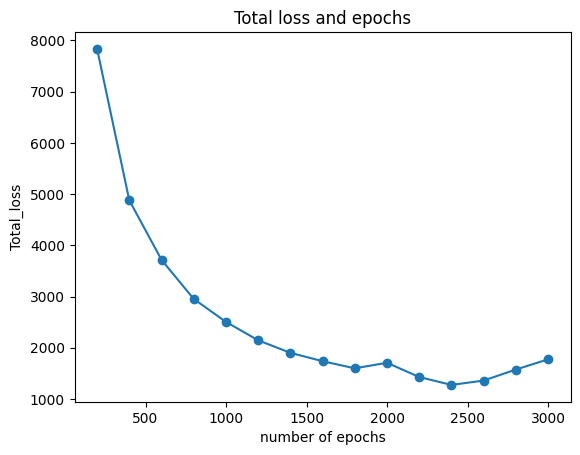

In [ ]:
plt.plot(num_epoch, total_lossx, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('number of epochs')
plt.ylabel('Total_loss')
plt.title('Total loss and epochs')